<a href="https://colab.research.google.com/github/animesharma3/Spam-Detector-BERT-Pytorch-Transformers-Hugging-Face-NLP-State-of-the-Art-Model./blob/main/Spam_Detector_%7C_BERT_%7C_Pytorch_%7C_Transformers_%7C_Hugging_Face_%7C_NLP_%7C_State_of_the_Art_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing Dependencies

In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertConfig
from transformers.models.bert.modeling_bert import BertEmbeddings
import warnings
from torch.utils.data import random_split
warnings.filterwarnings('ignore')


# Setting Variables

In [3]:
PRE_TRAINED_MODEL_NAME = 'prajjwal1/bert-tiny'
device = 'cuda'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
EPOCHS=10
MAX_LEN=512
BATCH_SIZE=16


# Reading and Preprocessing Data

In [4]:
df_sms = pd.read_csv('https://raw.githubusercontent.com/animesharma3/SPAM-SMS-Detection/master/spam_sms_collection.csv')[['msg', 'spam']]

df_tweet = pd.read_csv('tweet_train.csv')[['Tweet', 'Type']]
df_tweet['msg'] = df_tweet['Tweet']
df_tweet['spam'] = (1 * (df_tweet['Type'] == 'Quality'))

df_email = pd.read_csv('email_spam.csv')
df_email['msg'] = df_email['text']
df_email['spam'] = df_email['label_num']

df_youtube = pd.read_csv('youtube_train.csv')
df_youtube['msg'] = df_youtube['CONTENT']
df_youtube['spam'] = df_youtube['CLASS']

In [5]:
train_portion = 0.8
dfs = [df_sms, df_tweet, df_email, df_youtube]
data_names = ['sms', 'tweet','email','youtube']
df_vals = {}
df_combined = pd.DataFrame([], columns=['msg', 'spam'])
df_tests = {}
for i, df in enumerate(dfs):
  df_train, df_test = tts(
      df,
      test_size=0.3,
      shuffle=True,
  )
  df_val, df_test = tts(
    df_test,
    test_size=0.5,
    shuffle=True,
  )
  df_combined = pd.concat([df_combined, df_train[['msg','spam']]])
  df_vals[data_names[i]] = df_val
  df_tests[data_names[i]] = df_test

df_combined['spam'] = df_combined['spam'].astype(int)

In [6]:
df_combined = df_combined.reset_index(drop=True)
df_combined['spam']

0        0
1        1
2        0
3        0
4        0
        ..
17260    1
17261    1
17262    1
17263    0
17264    0
Name: spam, Length: 17265, dtype: int64

In [7]:
class SpamDataset(Dataset):
    def __init__(self, spam, msgs, tokenizer, max_len):
        self.msgs = msgs
        self.spam = spam
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.msgs)

    def __getitem__(self, i):
        msg = str(self.msgs[i])
        spam = self.spam[i]

        encoding = self.tokenizer.encode_plus(
            msg, 
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'msg': msg,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'spam': torch.tensor(spam, dtype=torch.long)
        }

In [8]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = SpamDataset(
        spam=df['spam'].to_numpy(),
        msgs=df['msg'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [9]:
# df_train, df_test = tts(
#     df_combined,
#     test_size=0.2,
#     random_state=42,
#     shuffle=True,
# )
# df_val, _ = tts(
#     df,
#     test_size=0.5,
#     random_state=42,
#     shuffle=True,
# )
# df_train.shape, df_test.shape, df_val.shape


In [10]:
train_data_loader = create_data_loader(df_combined, tokenizer, MAX_LEN, BATCH_SIZE)

test_data_loader = {}
val_data_loader = {}

for k, v in df_tests.items():
  data_loader = create_data_loader(v, tokenizer, MAX_LEN, BATCH_SIZE)
  test_data_loader[k] = data_loader

for k, v in df_vals.items():
  data_loader = create_data_loader(v, tokenizer, MAX_LEN, BATCH_SIZE)
  val_data_loader[k] = data_loader

In [11]:
d = next(iter(train_data_loader))
d.keys()

dict_keys(['msg', 'input_ids', 'attention_mask', 'spam'])

In [12]:
print(d['input_ids'].shape, d['attention_mask'].shape, d['spam'].shape)
print(d['input_ids'])


torch.Size([16, 512]) torch.Size([16, 512]) torch.Size([16])
tensor([[  101,  1057,  5305,  ...,     0,     0,     0],
        [  101, 24471,  2183,  ...,     0,     0,     0],
        [  101,  2655,  2360,  ...,     0,     0,     0],
        ...,
        [  101,  3419,  2906,  ...,     0,     0,     0],
        [  101, 12074,  3246,  ...,     0,     0,     0],
        [  101,  2228,  9092,  ...,     0,     0,     0]])


# Model Building

In [13]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class biLSTM(nn.Module):
    def __init__(self, h_dim=100, max_len=MAX_LEN, emd_dim=100, lstm_layers=1, dropout_rate=0.2):
        super(biLSTM, self).__init__()
        self.embeddings = self.bert = BertModel.from_pretrained(
            PRE_TRAINED_MODEL_NAME).get_input_embeddings()
        print(self.embeddings)

        self.text_len = max_len
        self.lstm_layers = lstm_layers
        self.h_dim = h_dim
        
        # self.embedding = nn.Embedding(max_len, max_len, padding_idx=0)
        self.lstm = nn.LSTM(input_size=128,
                            hidden_size=h_dim,
                            num_layers=lstm_layers,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(2 * lstm_layers * h_dim, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        N, L = input_ids.shape
        embedding_output = self.embeddings(input_ids)
        out, (h, c) = self.lstm(embedding_output)
        h = h.permute(1, 0, 2).resize(N, 2 * self.lstm_layers * self.h_dim)

        return torch.sigmoid(self.fc(h))


In [14]:
model = biLSTM(h_dim=100, lstm_layers=2).to(device)


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(30522, 128, padding_idx=0)


# Loss, Optimizer and Scheduler

In [15]:
optimizer = AdamW(model.parameters(), lr=2e-3, correct_bias=False)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [16]:
# input_ids = d['input_ids'].to(device)
# attention_mask = d['attention_mask'].to(device)
# targets = d['spam'].to(device)

# outputs = model(
#     input_ids=input_ids,
#     attention_mask=attention_mask
# )
# loss = loss_fn(outputs, targets)
# loss

# Train Model Function

In [17]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    device,
    data_loader,
    n_examples
):
    model = model.train() # Setting Model in training mode

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)  # [16, 512]
        attention_mask = d['attention_mask'].to(device)  # [16, 512]
        targets = d['spam'].to(device)  # [16]

        # Forward Propogation
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        ) # [16, 3]

        # Calculating Loss
        loss = loss_fn(outputs, targets)

        _, preds = torch.max(outputs, dim=1)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward Propogation
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clipping Gradient (Exploding Gradient Problem)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad() # Resetting gradients

    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)
    
    return train_acc, train_loss


# Validating Model Function

In [18]:
def evaluate_model(
    model,
    loss_fn,
    device,
    data_loader,
    n_examples   
):
    model = model.eval() # Setting Model in evaluation mode

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)  # [16, 512]
            attention_mask = d['attention_mask'].to(device)  # [16, 512]
            targets = d['spam'].to(device)  # [16]

            # Forward Propogation
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            ) # [16, 3]

            # Calculating Loss
            loss = loss_fn(outputs, targets)

            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        
    train_acc = correct_predictions.double() / n_examples
    train_loss = np.mean(losses)

    return train_acc, train_loss


# Training the Model

In [19]:
%%time


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train(
        model,
        loss_fn,
        optimizer,
        scheduler,
        device,
        train_data_loader,
        len(df_combined)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    for k, data_loader in val_data_loader.items():
      val_acc, val_loss = evaluate_model(
          model,
          loss_fn,
          device,
          data_loader,
          len(df_vals[k])
      )
      print(k)
      print(f'Validation loss {val_loss} accuracy {val_acc}')
      print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/10
----------
Train loss 0.626864622892053 accuracy 0.676339415001448
sms
Validation loss 0.5286443919505713 accuracy 0.784688995215311

tweet
Validation loss 0.52719119164796 accuracy 0.7532033426183844

email
Validation loss 0.4678044112361207 accuracy 0.8569587628865979

youtube
Validation loss 0.4742093447007631 accuracy 0.8361774744027304

Epoch 2/10
----------
Train loss 0.40858914750041786 accuracy 0.9002027222704895
sms
Validation loss 0.37561730281361994 accuracy 0.94377990430622

tweet
Validation loss 0.5185471817982935 accuracy 0.7855153203342619

email
Validation loss 0.3994029225135336 accuracy 0.9110824742268041

youtube
Validation loss 0.3960668209351991 accuracy 0.9215017064846417

Epoch 3/10
----------
Train loss 0.3570283015569051 accuracy 0.9554590211410368
sms
Validation loss 0.3631053403863367 accuracy 0.9485645933014354

tweet
Validation loss 0.5175609973679601 accuracy 0.7905292479108635

email
Validation loss 0.40024563548516257 accuracy 0.91237113402061

# Evaluating the Model Performance

In [ ]:
test_acc, _ = evaluate_model(
    model,
    loss_fn,
    device,
    test_data_loader,
    len(df_test)
)
test_acc.item()

0.9001670843776106

(0.0, 1.0)

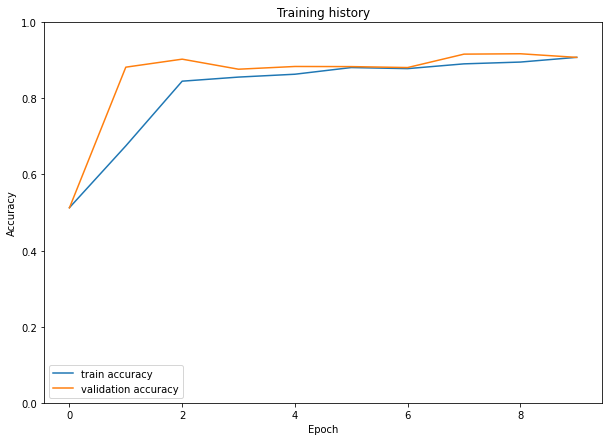

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [ ]:
def get_predictions(
    model, data_loader
):
    model = model.eval()

    msgs = []
    predictions = []
    predictions_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            msg = d['msg']
            input_ids = d['input_ids'].to(device)
            attention_masks = d['attention_mask'].to(device)
            spam = d['spam'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_masks
            )

            _, preds = torch.max(outputs, dim=1)

            probs = torch.nn.functional.softmax(outputs, dim=1)

            msgs.extend(msg)
            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(spam)
    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return msgs, predictions, predictions_probs, real_values

In [ ]:
y_msgs, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# Creating Final Classification Report

In [ ]:
def create_classification_report(Y_test, Y_pred):
    print('--------Classification Report---------\n')
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)
    metrices = [accuracy, f1, precision, recall, roc_auc]
    scores = pd.DataFrame(pd.Series(metrices).values, index=['accuracy', 'f1-score', 'precision', 'recall', 'roc auc score'], columns=['score'])
    print(scores)
    print('\n--------Plotting Confusion Matrix---------')
    sns.heatmap(confusion_matrix(Y_test, Y_pred), annot=True, cmap='RdYlGn_r', annot_kws={'size': 16})
    return scores

--------Classification Report---------

                  score
accuracy       0.900167
f1-score       0.903668
precision      0.873733
recall         0.935726
roc auc score  0.900137

--------Plotting Confusion Matrix---------


,score
accuracy,0.900167
f1-score,0.903668
precision,0.873733
recall,0.935726
roc auc score,0.900137


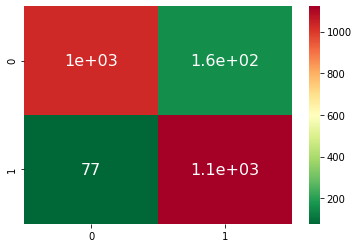

In [ ]:
create_classification_report(y_test, y_pred)

In [ ]:
torch.save(model, 'bert.pt')
